In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR
#torch.multiprocessing.set_start_method("spawn")
import resnet 

import numpy as np
import pandas as pd
from utils import progress_bar

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
BASE_dir = 'data/processed/'

train = pd.read_json(BASE_dir + 'train.json')
test = pd.read_json(BASE_dir + 'test.json')

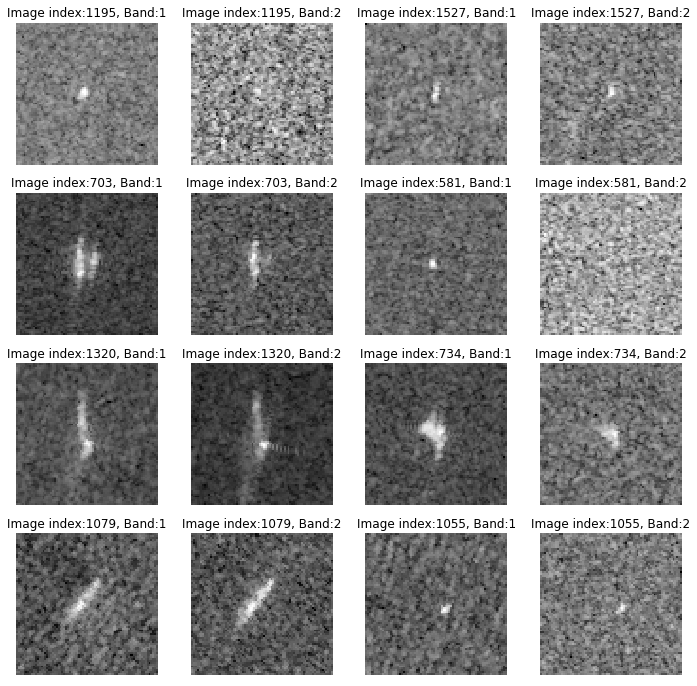

In [3]:
len(train) # 1604 obs
train.head(3)
#randomly draw some of them

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(4,4)

index = np.random.choice(list(range(len(train))),size=8, replace=False)
for num,i in enumerate(index):
    for j in range(2):
        ax = plt.subplot(gs[num*2+j])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title('Image index:%d, Band:%d' % (i, j%2+1))
        ax.set_aspect('equal')
        plt.imshow(np.array(train.iloc[i,j%2]).reshape(75,75))

In [15]:
#prepare data
use_cuda= True if torch.cuda.is_available() else False
#use_cuda =False
#dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor 
dtype = torch.FloatTensor 
data=  pd.read_json(BASE_dir + 'train.json')

class iceberg_dataset(Dataset):
    def __init__(self, data, label, transform=None): #data: 1604 * 3 *75* 75
        self.data =data
        self.label = torch.from_numpy(label).type(torch.LongTensor)
        self.transform= transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img, label=  self.data[idx], self.label[idx]
        if self.transform is not None:
            #Random Horizontal Flip and Vertical Flip 
            #https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663
            if np.random.uniform()>0.5:
                img = np.flip(img,axis=1).copy()
            if np.random.uniform()>0.5:
                img = np.flip(img,axis=2).copy()
            rotate = np.random.randint(4, size=1)
            if rotate:
                img = np.rot90(img,k=rotate,axes=(1,2)).copy()
            img = torch.from_numpy(img).type(dtype)
            img = self.transform(img)

        return img, label

def stack(row):
    return np.stack(row[['c1','c2','c3']]).reshape(3,75,75)

def raw_to_numpy(data):
    img = []
    data['c1'] = data['band_1'].apply(np.array)
    data['c2'] = data['band_2'].apply(np.array)
    data['c3'] = (data['c1'] + data['c2'])/2
#     data['c3'] = (data['c1'] + data['c2'])/2
    for _, row in data.iterrows():
        img.append(stack(row))
    return np.stack(img)

def transform_compute(img):
    train_mean = img.mean(axis=(0,2,3))
    train_std = img.std(axis=(0,2,3))
    return train_mean, train_std

train_X = raw_to_numpy(data)#.transpose(0,2,3,1)
train_X.shape     #1604 * 3 *75* 75   N*c*H*W
train_y = data['is_iceberg'].values # if iceberg then 1

In [16]:
train_index=list(range(1300)) 
val_index= list(range(1300,1604))
train_X[train_index].shape

train_mean, train_std = transform_compute(train_X[train_index])
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])

train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

In [6]:
torch.cuda.is_available()
torch.from_numpy(train_X).type(torch.FloatTensor)[1].shape
train_X[1]
use_cuda

True

In [24]:
resnet101 = resnet.resnet18(num_classes=2)

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here
optimizer = optim.SGD(resnet101.parameters(), lr=0.1, momentum=0.9, weight_decay=0.001, nesterov= True)
scheduler = MultiStepLR(optimizer, [50,70,85,100], gamma=0.1)
#5e-3 86
if use_cuda:
    criterion.cuda()
    resnet101.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   
net= resnet101

In [26]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    best_acc =0
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        scheduler.step()
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                e_s = 0
                torch.save(net.state_dict(), 'resnet101.pth')
        if early_stopping is not None and e_s >= early_stopping:
            return best_acc,i

    return best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc

train(epoch=120)


This is epoch:1
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s40ms | Loss: 0.789 | Acc: 65.615% (853/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 11.252 | Acc: 51.645% (157/304)

This is epoch:2
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s22ms | Loss: 0.783 | Acc: 62.692% (815/1300))
[=================== 5/5 ============>........]  Step: 146ms | Tot: 637ms | Loss: 0.633 | Acc: 52.303% (159/304)

This is epoch:3
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s26ms | Loss: 0.629 | Acc: 65.385% (850/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.728 | Acc: 50.000% (152/304)

This is epoch:4
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s18ms | Loss: 0.584 | Acc: 67.231% (874/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 632ms | Loss: 0.818 | Acc: 46.711% (142/304)

This is ep

[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.379 | Acc: 78.289% (238/304)

This is epoch:34
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s34ms | Loss: 0.282 | Acc: 87.462% (1137/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 632ms | Loss: 0.379 | Acc: 82.566% (251/304)

This is epoch:35
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s22ms | Loss: 0.271 | Acc: 88.769% (1154/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.480 | Acc: 78.289% (238/304)

This is epoch:36
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s34ms | Loss: 0.276 | Acc: 87.692% (1140/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 1.036 | Acc: 61.842% (188/304)

This is epoch:37
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s40ms | Loss: 0.271 | Acc: 88.538% (1151/1300))
[===

[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s28ms | Loss: 0.204 | Acc: 92.231% (1199/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.256 | Acc: 88.816% (270/304)

This is epoch:67
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s44ms | Loss: 0.191 | Acc: 92.077% (1197/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 639ms | Loss: 0.270 | Acc: 88.158% (268/304)

This is epoch:68
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s21ms | Loss: 0.188 | Acc: 92.923% (1208/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.274 | Acc: 88.158% (268/304)

This is epoch:69
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.208 | Acc: 91.385% (1188/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.283 | Acc: 86.513% (263/304)

This is epoch:70
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.255 | Acc: 89.474% (272/304)

This is epoch:99
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s37ms | Loss: 0.176 | Acc: 93.462% (1215/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.266 | Acc: 88.487% (269/304)

This is epoch:100
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s30ms | Loss: 0.164 | Acc: 93.077% (1210/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.249 | Acc: 89.145% (271/304)

This is epoch:101
[=================== 41/41 =================>.]  Step: 426ms | Tot: 15s35ms | Loss: 0.174 | Acc: 93.077% (1210/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.253 | Acc: 89.145% (271/304)

This is epoch:102
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s49ms | Loss: 0.179 | Acc: 92.692% (1205/1300))
[

(90.78947368421052, 119)

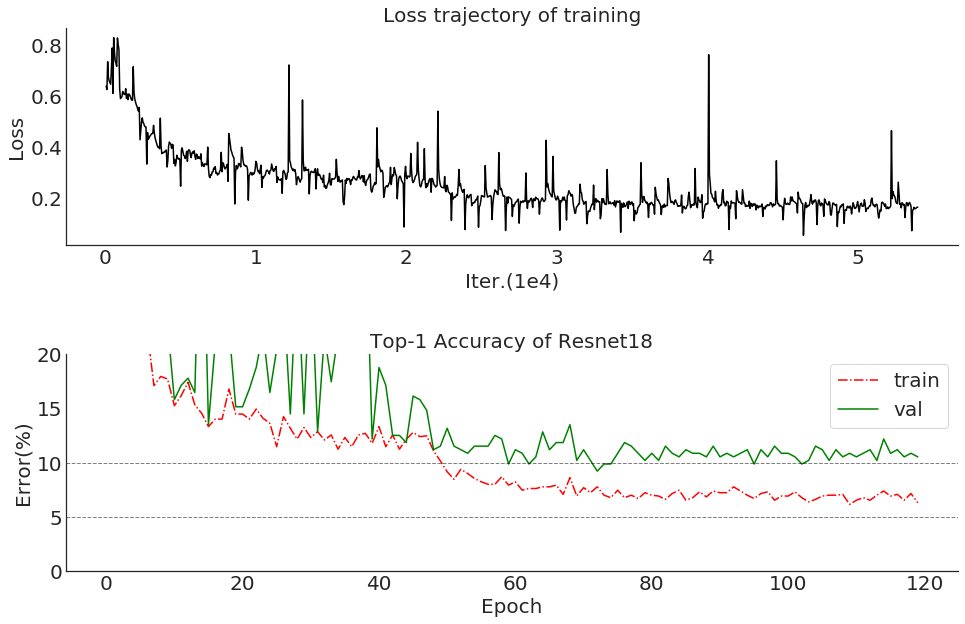

In [27]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)')

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet18',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')

In [19]:
#Bayesian optimization

from bayes_opt import BayesianOptimization

opt_hist=[]
def resnet_evaluate(lr,wd):
    global net,criterion, optimizer,scheduler
    
    net = resnet.resnet18(num_classes=2)

    criterion = nn.CrossEntropyLoss()

    #Adam does not perform so good here
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd, nesterov= True)
    scheduler = MultiStepLR(optimizer, [30,60,90], gamma=0.1)
    #5e-3 86
    if use_cuda:
        criterion.cuda()
        net.cuda()
    result = train(epoch=120,early_stopping=25)
    opt_hist.append(result)
    return result[0]

resnetOB = BayesianOptimization(resnet_evaluate, {'lr': (0.0001, 0.1),
                                                   'wd':(0.0001, 0.1)
                                                 })

resnetOB.explore({
'lr': (0.1, 0.01,0.001,0.1, 0.01,0.001),
'wd':(0.0001, 0.0001,0.0001,0.001,0.002,0.003)
})



resnetOB.maximize(init_points=3, n_iter=10,acq='ei', xi=0.05)

Initialization
-----------------------------------------------------
 Step |   Time |      Value |        lr |        wd | 

This is epoch:1
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s44ms | Loss: 3.181 | Acc: 57.462% (747/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 45.076 | Acc: 35.526% (108/304)

This is epoch:2
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s15ms | Loss: 0.792 | Acc: 61.154% (795/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.824 | Acc: 46.711% (142/304)

This is epoch:3
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s27ms | Loss: 0.662 | Acc: 64.385% (837/1300))
[=================== 5/5 ============>........]  Step: 143ms | Tot: 632ms | Loss: 0.670 | Acc: 55.592% (169/304)

This is epoch:4
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s4ms | Loss: 0.744 | Acc: 62.923% (818/1300)0)


[=================== 41/41 =================>.]  Step: 431ms | Tot: 15s30ms | Loss: 0.292 | Acc: 87.538% (1138/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.320 | Acc: 83.224% (253/304)

This is epoch:34
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s19ms | Loss: 0.273 | Acc: 88.538% (1151/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.348 | Acc: 83.553% (254/304)

This is epoch:35
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s34ms | Loss: 0.271 | Acc: 88.231% (1147/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.337 | Acc: 84.868% (258/304)

This is epoch:36
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s29ms | Loss: 0.279 | Acc: 87.462% (1137/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.341 | Acc: 82.895% (252/304)

This is epoch:37
[===

[=================== 5/5 ============>........]  Step: 143ms | Tot: 633ms | Loss: 0.297 | Acc: 86.842% (264/304)

This is epoch:66
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s29ms | Loss: 0.237 | Acc: 90.538% (1177/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.307 | Acc: 85.526% (260/304)

This is epoch:67
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s26ms | Loss: 0.243 | Acc: 90.154% (1172/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.318 | Acc: 84.539% (257/304)

This is epoch:68
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s20ms | Loss: 0.249 | Acc: 89.385% (1162/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.299 | Acc: 86.184% (262/304)

This is epoch:69
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s33ms | Loss: 0.245 | Acc: 90.615% (1178/1300))
[===

[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s23ms | Loss: 0.228 | Acc: 90.462% (1176/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.277 | Acc: 87.829% (267/304)

This is epoch:99
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s35ms | Loss: 0.228 | Acc: 90.000% (1170/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.304 | Acc: 86.513% (263/304)

This is epoch:100
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s21ms | Loss: 0.230 | Acc: 90.308% (1174/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.272 | Acc: 88.158% (268/304)

This is epoch:101
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s25ms | Loss: 0.229 | Acc: 90.769% (1180/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 629ms | Loss: 0.286 | Acc: 87.171% (265/304)

This is epoch:102
[

[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.250 | Acc: 88.158% (268/304)

This is epoch:20
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s45ms | Loss: 0.184 | Acc: 93.077% (1210/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 630ms | Loss: 0.394 | Acc: 82.566% (251/304)

This is epoch:21
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.209 | Acc: 91.154% (1185/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.571 | Acc: 76.316% (232/304)

This is epoch:22
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.208 | Acc: 91.692% (1192/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.444 | Acc: 83.224% (253/304)

This is epoch:23
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s41ms | Loss: 0.191 | Acc: 92.077% (1197/1300))
[===

[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s36ms | Loss: 0.050 | Acc: 98.308% (1278/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.465 | Acc: 85.526% (260/304)

This is epoch:53
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s43ms | Loss: 0.040 | Acc: 98.923% (1286/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.408 | Acc: 86.513% (263/304)

This is epoch:54
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s34ms | Loss: 0.048 | Acc: 98.462% (1280/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.401 | Acc: 87.829% (267/304)
    2 | 15m01s |   89.47368 |    0.0100 |    0.0001 | 

This is epoch:1
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s55ms | Loss: 0.606 | Acc: 64.846% (843/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 

[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.300 | Acc: 86.184% (262/304)

This is epoch:31
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s45ms | Loss: 0.178 | Acc: 93.462% (1215/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.346 | Acc: 84.539% (257/304)

This is epoch:32
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s41ms | Loss: 0.182 | Acc: 92.923% (1208/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.317 | Acc: 87.171% (265/304)

This is epoch:33
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s40ms | Loss: 0.177 | Acc: 93.154% (1211/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.332 | Acc: 84.868% (258/304)

This is epoch:34
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s25ms | Loss: 0.175 | Acc: 93.462% (1215/1300))
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s35ms | Loss: 0.439 | Acc: 79.077% (1028/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 632ms | Loss: 0.539 | Acc: 70.066% (213/304)

This is epoch:10
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s31ms | Loss: 0.372 | Acc: 83.231% (1082/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 631ms | Loss: 0.528 | Acc: 75.000% (228/304)

This is epoch:11
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s34ms | Loss: 0.362 | Acc: 83.308% (1083/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.465 | Acc: 73.026% (222/304)

This is epoch:12
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s28ms | Loss: 0.317 | Acc: 86.231% (1121/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.532 | Acc: 73.684% (224/304)

This is epoch:13
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.258 | Acc: 90.461% (275/304)

This is epoch:42
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s47ms | Loss: 0.213 | Acc: 91.077% (1184/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.246 | Acc: 91.118% (277/304)

This is epoch:43
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s52ms | Loss: 0.209 | Acc: 91.000% (1183/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 639ms | Loss: 0.269 | Acc: 88.816% (270/304)

This is epoch:44
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s37ms | Loss: 0.211 | Acc: 91.769% (1193/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.287 | Acc: 87.171% (265/304)

This is epoch:45
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.200 | Acc: 92.000% (1196/1300))
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s32ms | Loss: 0.284 | Acc: 87.385% (1136/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.416 | Acc: 78.289% (238/304)

This is epoch:10
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s44ms | Loss: 0.263 | Acc: 88.385% (1149/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 631ms | Loss: 0.476 | Acc: 76.645% (233/304)

This is epoch:11
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s44ms | Loss: 0.254 | Acc: 90.077% (1171/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.324 | Acc: 83.882% (255/304)

This is epoch:12
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s29ms | Loss: 0.265 | Acc: 88.769% (1154/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.301 | Acc: 86.184% (262/304)

This is epoch:13
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.589 | Acc: 63.816% (194/304)

This is epoch:4
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s46ms | Loss: 0.443 | Acc: 79.923% (1039/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.496 | Acc: 71.053% (216/304)

This is epoch:5
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s38ms | Loss: 0.426 | Acc: 80.462% (1046/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.473 | Acc: 74.342% (226/304)

This is epoch:6
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s39ms | Loss: 0.389 | Acc: 83.077% (1080/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.485 | Acc: 72.697% (221/304)

This is epoch:7
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.376 | Acc: 83.385% (1084/1300))
[=======

[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s33ms | Loss: 0.149 | Acc: 94.538% (1229/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.287 | Acc: 85.526% (260/304)

This is epoch:37
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s59ms | Loss: 0.184 | Acc: 93.231% (1212/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.345 | Acc: 83.553% (254/304)

This is epoch:38
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s67ms | Loss: 0.167 | Acc: 93.769% (1219/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.310 | Acc: 86.513% (263/304)

This is epoch:39
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s38ms | Loss: 0.148 | Acc: 94.231% (1225/1300))
[=================== 5/5 ============>........]  Step: 146ms | Tot: 636ms | Loss: 0.320 | Acc: 85.526% (260/304)

This is epoch:40
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.708 | Acc: 33.553% (102/304)

This is epoch:18
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s18ms | Loss: 0.694 | Acc: 52.385% (681/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.740 | Acc: 33.553% (102/304)

This is epoch:19
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s12ms | Loss: 0.698 | Acc: 48.846% (635/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 633ms | Loss: 0.683 | Acc: 66.447% (202/304)

This is epoch:20
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s11ms | Loss: 0.695 | Acc: 50.231% (653/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.687 | Acc: 66.447% (202/304)

This is epoch:21
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s26ms | Loss: 0.696 | Acc: 51.308% (667/1300))
[=======

[=================== 41/41 =================>.]  Step: 428ms | Tot: 14s998ms | Loss: 0.540 | Acc: 71.846% (934/1300)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.830 | Acc: 33.553% (102/304)

This is epoch:18
[=================== 41/41 =================>.]  Step: 429ms | Tot: 14s997ms | Loss: 0.534 | Acc: 73.077% (950/1300)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.718 | Acc: 40.789% (124/304)

This is epoch:19
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s6ms | Loss: 0.587 | Acc: 68.846% (895/1300)0)
[=================== 5/5 ============>........]  Step: 145ms | Tot: 634ms | Loss: 0.838 | Acc: 33.553% (102/304)

This is epoch:20
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s2ms | Loss: 0.551 | Acc: 71.692% (932/1300)0)
[=================== 5/5 ============>........]  Step: 143ms | Tot: 636ms | Loss: 0.556 | Acc: 66.447% (202/304)

This is epoch:21
[=======

[=================== 41/41 =================>.]  Step: 427ms | Tot: 14s989ms | Loss: 0.397 | Acc: 83.615% (1087/1300)
[=================== 5/5 ============>........]  Step: 145ms | Tot: 639ms | Loss: 0.783 | Acc: 56.908% (173/304)

This is epoch:51
[=================== 41/41 =================>.]  Step: 427ms | Tot: 14s989ms | Loss: 0.388 | Acc: 82.923% (1078/1300)
[=================== 5/5 ============>........]  Step: 145ms | Tot: 636ms | Loss: 0.495 | Acc: 77.303% (235/304)

This is epoch:52
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s9ms | Loss: 0.409 | Acc: 82.308% (1070/1300)0)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.507 | Acc: 75.658% (230/304)

This is epoch:53
[=================== 41/41 =================>.]  Step: 429ms | Tot: 14s987ms | Loss: 0.383 | Acc: 84.385% (1097/1300)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.511 | Acc: 74.013% (225/304)

This is epoch:54
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 1.443 | Acc: 35.526% (108/304)

This is epoch:10
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s56ms | Loss: 0.328 | Acc: 86.462% (1124/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 640ms | Loss: 0.479 | Acc: 71.053% (216/304)

This is epoch:11
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s39ms | Loss: 0.329 | Acc: 85.769% (1115/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.558 | Acc: 68.092% (207/304)

This is epoch:12
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s29ms | Loss: 0.330 | Acc: 85.077% (1106/1300))
[=================== 5/5 ============>........]  Step: 143ms | Tot: 634ms | Loss: 0.931 | Acc: 51.316% (156/304)

This is epoch:13
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s39ms | Loss: 0.353 | Acc: 83.615% (1087/1300))
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s33ms | Loss: 0.264 | Acc: 90.077% (1171/1300))
[=================== 5/5 ============>........]  Step: 143ms | Tot: 633ms | Loss: 0.335 | Acc: 85.526% (260/304)

This is epoch:43
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s45ms | Loss: 0.279 | Acc: 89.385% (1162/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.279 | Acc: 89.803% (273/304)

This is epoch:44
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s33ms | Loss: 0.268 | Acc: 89.923% (1169/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.369 | Acc: 83.882% (255/304)

This is epoch:45
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s53ms | Loss: 0.264 | Acc: 90.385% (1175/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.515 | Acc: 75.987% (231/304)

This is epoch:46
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.260 | Acc: 88.487% (269/304)

This is epoch:75
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.220 | Acc: 92.846% (1207/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.268 | Acc: 88.487% (269/304)

This is epoch:76
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s30ms | Loss: 0.234 | Acc: 92.000% (1196/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.275 | Acc: 87.829% (267/304)

This is epoch:77
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s30ms | Loss: 0.226 | Acc: 92.154% (1198/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.280 | Acc: 87.829% (267/304)
    9 | 21m24s |   91.11842 |    0.0091 |    0.0481 | 
Bayesian Optimization
-----------------------------------------------------
 Step |  

[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.559 | Acc: 66.447% (202/304)

This is epoch:30
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s24ms | Loss: 0.439 | Acc: 80.692% (1049/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.826 | Acc: 51.316% (156/304)

This is epoch:31
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s16ms | Loss: 0.441 | Acc: 80.077% (1041/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 633ms | Loss: 0.592 | Acc: 66.776% (203/304)

This is epoch:32
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s10ms | Loss: 0.399 | Acc: 83.308% (1083/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.469 | Acc: 74.671% (227/304)

This is epoch:33
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s27ms | Loss: 0.370 | Acc: 84.615% (1100/1300))
[===

[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s42ms | Loss: 0.248 | Acc: 89.923% (1169/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.286 | Acc: 87.171% (265/304)

This is epoch:63
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s39ms | Loss: 0.236 | Acc: 90.385% (1175/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 641ms | Loss: 0.330 | Acc: 87.171% (265/304)

This is epoch:64
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s21ms | Loss: 0.222 | Acc: 91.615% (1191/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.316 | Acc: 86.184% (262/304)

This is epoch:65
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s20ms | Loss: 0.223 | Acc: 91.462% (1189/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.275 | Acc: 89.474% (272/304)

This is epoch:66
[===

[=================== 5/5 ============>........]  Step: 145ms | Tot: 631ms | Loss: 0.261 | Acc: 89.803% (273/304)

This is epoch:95
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s13ms | Loss: 0.198 | Acc: 92.308% (1200/1300))
[=================== 5/5 ============>........]  Step: 148ms | Tot: 641ms | Loss: 0.270 | Acc: 89.803% (273/304)

This is epoch:96
[=================== 41/41 =================>.]  Step: 427ms | Tot: 14s997ms | Loss: 0.189 | Acc: 92.923% (1208/1300)
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.292 | Acc: 88.487% (269/304)

This is epoch:97
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s12ms | Loss: 0.205 | Acc: 92.462% (1202/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.283 | Acc: 88.487% (269/304)

This is epoch:98
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s11ms | Loss: 0.203 | Acc: 92.000% (1196/1300))
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s40ms | Loss: 0.284 | Acc: 88.538% (1151/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 632ms | Loss: 0.354 | Acc: 83.882% (255/304)

This is epoch:15
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s41ms | Loss: 0.264 | Acc: 88.538% (1151/1300))
[=================== 5/5 ============>........]  Step: 146ms | Tot: 637ms | Loss: 0.492 | Acc: 73.026% (222/304)

This is epoch:16
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s33ms | Loss: 0.250 | Acc: 90.000% (1170/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.366 | Acc: 83.882% (255/304)

This is epoch:17
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.242 | Acc: 89.308% (1161/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 629ms | Loss: 0.235 | Acc: 91.447% (278/304)

This is epoch:18
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 632ms | Loss: 0.715 | Acc: 46.382% (141/304)

This is epoch:5
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s37ms | Loss: 0.541 | Acc: 71.615% (931/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 630ms | Loss: 0.784 | Acc: 54.276% (165/304)

This is epoch:6
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s27ms | Loss: 0.524 | Acc: 73.385% (954/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.737 | Acc: 44.079% (134/304)

This is epoch:7
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s32ms | Loss: 0.471 | Acc: 77.769% (1011/1300)
[=================== 5/5 ============>........]  Step: 147ms | Tot: 638ms | Loss: 0.843 | Acc: 40.461% (123/304)

This is epoch:8
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s39ms | Loss: 0.462 | Acc: 79.000% (1027/1300))
[==========

[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s54ms | Loss: 0.251 | Acc: 89.077% (1158/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.328 | Acc: 86.184% (262/304)

This is epoch:38
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s72ms | Loss: 0.245 | Acc: 88.923% (1156/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.294 | Acc: 87.171% (265/304)

This is epoch:39
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s50ms | Loss: 0.238 | Acc: 89.692% (1166/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.286 | Acc: 86.842% (264/304)

This is epoch:40
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s28ms | Loss: 0.241 | Acc: 89.308% (1161/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.301 | Acc: 84.539% (257/304)

This is epoch:41
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.287 | Acc: 87.500% (266/304)

This is epoch:70
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s41ms | Loss: 0.175 | Acc: 93.154% (1211/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.284 | Acc: 87.829% (267/304)

This is epoch:71
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s39ms | Loss: 0.184 | Acc: 92.692% (1205/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.290 | Acc: 87.500% (266/304)
   12 | 19m43s |   89.80263 |    0.0992 |    0.0027 | 

This is epoch:1
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s29ms | Loss: 1.412 | Acc: 64.846% (843/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.848 | Acc: 47.368% (144/304)

This is epoch:2
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15

[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s16ms | Loss: 0.305 | Acc: 85.769% (1115/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 631ms | Loss: 0.295 | Acc: 87.829% (267/304)

This is epoch:32
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s34ms | Loss: 0.252 | Acc: 88.846% (1155/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 629ms | Loss: 0.290 | Acc: 86.513% (263/304)

This is epoch:33
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s28ms | Loss: 0.249 | Acc: 89.308% (1161/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 640ms | Loss: 0.283 | Acc: 86.184% (262/304)

This is epoch:34
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s33ms | Loss: 0.232 | Acc: 89.692% (1166/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.277 | Acc: 87.829% (267/304)

This is epoch:35
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.292 | Acc: 88.487% (269/304)

This is epoch:64
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s55ms | Loss: 0.176 | Acc: 93.308% (1213/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.287 | Acc: 86.842% (264/304)

This is epoch:65
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s34ms | Loss: 0.171 | Acc: 93.846% (1220/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 631ms | Loss: 0.272 | Acc: 88.158% (268/304)

This is epoch:66
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s18ms | Loss: 0.160 | Acc: 93.692% (1218/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.271 | Acc: 88.158% (268/304)

This is epoch:67
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s16ms | Loss: 0.169 | Acc: 93.231% (1212/1300))
[===

[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s21ms | Loss: 0.520 | Acc: 75.692% (984/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.675 | Acc: 55.921% (170/304)

This is epoch:15
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s19ms | Loss: 0.458 | Acc: 78.923% (1026/1300))
[=================== 5/5 ============>........]  Step: 143ms | Tot: 633ms | Loss: 0.821 | Acc: 47.697% (145/304)

This is epoch:16
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s26ms | Loss: 0.481 | Acc: 77.923% (1013/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.681 | Acc: 59.211% (180/304)

This is epoch:17
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s12ms | Loss: 0.459 | Acc: 80.231% (1043/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 631ms | Loss: 0.601 | Acc: 65.789% (200/304)

This is epoch:18
[====

[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s10ms | Loss: 0.336 | Acc: 83.846% (1090/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.675 | Acc: 69.408% (211/304)

This is epoch:48
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s4ms | Loss: 0.329 | Acc: 84.154% (1094/1300)0)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.321 | Acc: 86.842% (264/304)

This is epoch:49
[=================== 41/41 =================>.]  Step: 428ms | Tot: 14s998ms | Loss: 0.338 | Acc: 84.308% (1096/1300)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.352 | Acc: 84.868% (258/304)

This is epoch:50
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s10ms | Loss: 0.301 | Acc: 87.231% (1134/1300))
[=================== 5/5 ============>........]  Step: 143ms | Tot: 633ms | Loss: 0.321 | Acc: 85.197% (259/304)

This is epoch:51
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.318 | Acc: 85.855% (261/304)

This is epoch:80
[=================== 41/41 =================>.]  Step: 426ms | Tot: 15s7ms | Loss: 0.244 | Acc: 89.615% (1165/1300)0)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.286 | Acc: 86.513% (263/304)

This is epoch:81
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s6ms | Loss: 0.242 | Acc: 90.231% (1173/1300)0)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.317 | Acc: 85.526% (260/304)

This is epoch:82
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s20ms | Loss: 0.250 | Acc: 89.462% (1163/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.294 | Acc: 85.855% (261/304)

This is epoch:83
[=================== 41/41 =================>.]  Step: 428ms | Tot: 14s997ms | Loss: 0.249 | Acc: 89.231% (1160/1300)
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s38ms | Loss: 0.219 | Acc: 90.846% (1181/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.668 | Acc: 68.421% (208/304)

This is epoch:22
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s40ms | Loss: 0.221 | Acc: 91.538% (1190/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.249 | Acc: 91.118% (277/304)

This is epoch:23
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s40ms | Loss: 0.193 | Acc: 92.769% (1206/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.301 | Acc: 86.513% (263/304)

This is epoch:24
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s32ms | Loss: 0.225 | Acc: 91.154% (1185/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 636ms | Loss: 0.363 | Acc: 85.855% (261/304)

This is epoch:25
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.376 | Acc: 82.566% (251/304)

This is epoch:7
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s24ms | Loss: 0.317 | Acc: 86.308% (1122/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.428 | Acc: 80.592% (245/304)

This is epoch:8
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s47ms | Loss: 0.302 | Acc: 87.385% (1136/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.874 | Acc: 58.882% (179/304)

This is epoch:9
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s30ms | Loss: 0.293 | Acc: 87.692% (1140/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.535 | Acc: 78.289% (238/304)

This is epoch:10
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s31ms | Loss: 0.263 | Acc: 87.923% (1143/1300))
[======

[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s38ms | Loss: 0.072 | Acc: 97.846% (1272/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.345 | Acc: 86.842% (264/304)

This is epoch:40
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s35ms | Loss: 0.092 | Acc: 96.308% (1252/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.359 | Acc: 86.842% (264/304)

This is epoch:41
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s40ms | Loss: 0.079 | Acc: 97.000% (1261/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.309 | Acc: 89.145% (271/304)

This is epoch:42
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s40ms | Loss: 0.074 | Acc: 97.615% (1269/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.363 | Acc: 88.158% (268/304)

This is epoch:43
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 632ms | Loss: 0.388 | Acc: 88.487% (269/304)

This is epoch:72
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s41ms | Loss: 0.047 | Acc: 98.462% (1280/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.426 | Acc: 88.158% (268/304)

This is epoch:73
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s38ms | Loss: 0.031 | Acc: 99.154% (1289/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 631ms | Loss: 0.393 | Acc: 87.829% (267/304)

This is epoch:74
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s28ms | Loss: 0.024 | Acc: 99.308% (1291/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.416 | Acc: 88.158% (268/304)

This is epoch:75
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s39ms | Loss: 0.025 | Acc: 99.154% (1289/1300))
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s46ms | Loss: 0.179 | Acc: 91.923% (1195/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.271 | Acc: 90.461% (275/304)

This is epoch:27
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s58ms | Loss: 0.186 | Acc: 92.000% (1196/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.416 | Acc: 84.868% (258/304)

This is epoch:28
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s48ms | Loss: 0.178 | Acc: 93.385% (1214/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 638ms | Loss: 0.374 | Acc: 84.539% (257/304)

This is epoch:29
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s63ms | Loss: 0.196 | Acc: 91.077% (1184/1300))
[=================== 5/5 ============>........]  Step: 146ms | Tot: 638ms | Loss: 0.718 | Acc: 73.355% (223/304)

This is epoch:30
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.413 | Acc: 78.618% (239/304)

This is epoch:10
[=================== 41/41 =================>.]  Step: 431ms | Tot: 15s48ms | Loss: 0.286 | Acc: 88.462% (1150/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 630ms | Loss: 0.332 | Acc: 84.539% (257/304)

This is epoch:11
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s29ms | Loss: 0.285 | Acc: 88.077% (1145/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.553 | Acc: 74.013% (225/304)

This is epoch:12
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s48ms | Loss: 0.245 | Acc: 90.308% (1174/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.440 | Acc: 78.289% (238/304)

This is epoch:13
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s51ms | Loss: 0.229 | Acc: 90.231% (1173/1300))
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s28ms | Loss: 0.065 | Acc: 97.615% (1269/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.346 | Acc: 86.842% (264/304)

This is epoch:43
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s35ms | Loss: 0.064 | Acc: 98.000% (1274/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.354 | Acc: 86.842% (264/304)

This is epoch:44
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s45ms | Loss: 0.086 | Acc: 97.462% (1267/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.334 | Acc: 88.487% (269/304)

This is epoch:45
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s48ms | Loss: 0.063 | Acc: 97.846% (1272/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.384 | Acc: 85.855% (261/304)

This is epoch:46
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.414 | Acc: 80.263% (244/304)

This is epoch:25
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s46ms | Loss: 0.197 | Acc: 92.154% (1198/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.347 | Acc: 84.539% (257/304)

This is epoch:26
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s33ms | Loss: 0.202 | Acc: 91.692% (1192/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.262 | Acc: 88.487% (269/304)

This is epoch:27
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s42ms | Loss: 0.193 | Acc: 92.615% (1204/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.279 | Acc: 88.816% (270/304)

This is epoch:28
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s46ms | Loss: 0.192 | Acc: 91.923% (1195/1300))
[===

In [20]:
#30,60, 90 learning rate decay
#
resnetOB.res

{'all': {'params': [{'lr': 0.099969837126105854, 'wd': 0.0048768157841404631},
   {'lr': 0.005636454096473553, 'wd': 0.0012221947368002359},
   {'lr': 0.099246510214096528, 'wd': 0.0027344024076647543},
   {'lr': 0.099959725736288932, 'wd': 0.0024664062526430623},
   {'lr': 0.099422206390654952, 'wd': 0.0071210893402104142},
   {'lr': 0.0026487236284499088, 'wd': 0.0015270389790467936},
   {'lr': 0.0082483652834426258, 'wd': 0.0012592003869237804},
   {'lr': 0.0048465324038598672, 'wd': 0.0012104365001951837},
   {'lr': 0.0064880244084614732, 'wd': 0.0012612161415386236},
   {'lr': 0.0090556414439709517, 'wd': 0.0010343458814944075}],
  'values': [90.78947368421052,
   91.44736842105263,
   89.80263157894737,
   90.131578947368425,
   89.473684210526315,
   91.118421052631575,
   90.78947368421052,
   90.78947368421052,
   88.486842105263165,
   90.78947368421052]},
 'max': {'max_params': {'lr': 0.005636454096473553,
   'wd': 0.0012221947368002359},
  'max_val': 91.44736842105263}}

In [18]:
out1 = torch.cat((out.data,out.data),1)
out1.size()
# out
criterion(out,y.long())
type(predicted)
type(y.data)
#predicted.eq(y.data).cpu().sum()

torch.cuda.DoubleTensor

In [28]:
net = resnet.resnet18(num_classes=2)
net.load_state_dict(torch.load('resnet101.pth'))
net.cuda()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    temp = np.exp(out.cpu().data.numpy())
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))

[=================== 132/132 ================>]  Step: 125ms | Tot: 21s149ms


In [29]:
np.concatenate(prob).shape

(8424,)

In [30]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = np.concatenate(prob)
sub.shape
sub.to_csv('submission1.csv',index=False)